In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def out_to_csv(in_filename, out_filename):
    data = []
    i = -1
    with open(in_filename) as in_f:
        lines = in_f.readlines()
    for line in lines:
        if not isNumber(line):
            i += 1
            data.append([])
        else:
            data[i].append(int(line))
    with open(out_filename, 'w') as out_f:
        for i in range(len(data)):
            for j in range(len(data[i])):
                if j == len(data[i])-1:
                    out_f.write("{}\n".format(data[i][j]))
                else:
                    out_f.write("{},".format(data[i][j]))
        
    
def isNumber(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [19]:
spls = ['BSN', 'Email', 'IC', 'Lift', 'MP']

data_names = (
    ['totalTime{}Reana'.format(spl) for spl in spls]
    + ['totalTime{}ReanaE'.format(spl) for spl in spls])

print(data_names)

for data_name in data_names:
    out_to_csv('{}.out'.format(data_name), '{}.csv'.format(data_name))

['totalTimeBSNReana', 'totalTimeEmailReana', 'totalTimeICReana', 'totalTimeLiftReana', 'totalTimeMPReana', 'totalTimeBSNReanaE', 'totalTimeEmailReanaE', 'totalTimeICReanaE', 'totalTimeLiftReanaE', 'totalTimeMPReanaE']


In [38]:
def read_data(spl):
    (fn1, fn2) = ['totalTime{}{}.csv'.format(spl, t) for t in ['Reana', 'ReanaE']]
    
    df1 = pd.read_csv(fn1, header=None).transpose()
    df2 = pd.read_csv(fn2, header=None).transpose()
    
    n = min(df1.shape[0], df2.shape[0])
    print(n)
    if df1.shape[0] > n:
        rows = list(range(n, df1.shape[0]))
        print('Dropping rows {} from df1'.format(rows))
        df1 = df1.drop(rows)
    elif df2.shape[0] > n:
        rows = list(range(n, df2.shape[0]))
        print('Dropping rows {} from df2'.format(rows))
        df2 = df2.drop(rows)
        
    df = pd.concat([df1, df2], keys=['reana', 'reanae'])
    df /= 1000.0
    
    df['Type'] = np.repeat(['reana', 'reanaE'], [n, n], axis=0)
    return df

11
Dropping rows [11] from df2


0      1      2      3      4      5      6      7      8  \
reana  0   1.110  0.413  0.455  0.420  0.431  0.430  0.476  0.497  0.535   
       1   3.200  0.577  0.690  0.561  0.619  0.475  0.647  0.475  0.542   
       2   0.934  0.410  0.500  0.429  0.487  0.473  0.504  0.609  0.491   
       3   2.310  0.584  0.456  0.564  0.682  0.857  0.556  0.578  0.638   
       4   3.178  0.866  0.668  0.601  0.607  0.606  0.535  0.971  0.481   
       5   4.009  1.075  0.726  0.627  0.702  0.848  0.722  0.496  0.765   
       6   0.737  0.400  0.435  0.410  0.413  0.437  0.480  0.471  0.481   
       7   3.121  0.701  0.580  0.496  0.779  0.490  0.529  0.708  0.487   
       8   1.976  0.506  0.864  0.604  0.456  0.479  0.475  0.490  0.535   
       9   2.573  0.720  0.444  0.750  0.505  0.671  0.643  0.618  1.015   
       10  6.291  0.539  0.692  0.739  0.537  0.674  0.688  0.498  0.652   
reanae 0   1.379  0.464  0.411  0.605  0.352  0.371  0.372  0.385  0.432   
       1   0.401  0.397  0.368  0.372  0.378  0.411  0.391  0.408  0.411   
       2   4.676  0.492  0.500  0.404  0.394  0.463  0.388  0.399  0.463   
       3   3.396  0.501  0.496  0.400  0.417  0.446  0.433  0.399  0.458   
       4   0.836  0.371  0.372  0.434  0.364  0.446  0.429  0.490  0.488   
       5   3.055  0.563  0.409  0.548  0.423  0.557  0.450  0.508  0.515   
       6   0.736  0.387  0.357  0.350  0.368  0.362  0.385  0.402  0.462   
       7   2.087  0.638  0.417  0.481  0.372  0.461  0.449  0.420  0.519   
       8   4.392  0.569  0.432  0.462  0.548  0.474  0.376  0.424  0.463   
       9   0.821  0.456  0.355  0.377  0.370  0.405  0.423  0.399  0.425   
       10  1.067  0.407  0.389  0.373  0.461  0.384  0.407  0.453  0.558   

               9  ...     12     13     14     15      16      17       18  \
reana  0   0.558  ...  2.461  2.291  4.418  8.717  18.237  39.222  120.085   
       1   0.584  ...  2.524  2.280  4.528  8.814  17.831  39.442  118.258   
       2   0.563  ...  2.364  2.272  4.370  8.604  17.772  40.082  119.943   
       3   0.577  ...  2.518  2.379  4.366  8.670  17.577  40.192  116.758   
       4   0.645  ...  2.420  2.281  4.379  8.799  18.187  39.168  119.649   
       5   1.061  ...  2.394  2.258  4.435  8.472  17.387  39.137  121.215   
       6   0.513  ...  2.435  2.305  4.497  8.742  17.879  40.017  113.909   
       7   0.523  ...  2.403  2.308  4.765  8.687  17.701  38.000  114.644   
       8   0.540  ...  2.386  2.320  4.295  8.792  18.384  39.967  115.771   
       9   0.612  ...  2.673  2.275  4.523  8.865  17.701  39.049  107.854   
       10  0.571  ...  2.497  2.305  4.515  8.581  18.394  38.238  115.332   
reanae 0   0.473  ...  1.311  2.250  4.404  8.872  17.587  38.296   93.716   
       1   0.544  ...  1.275  2.268  4.576  9.112  17.888  38.012   89.688   
       2   0.534  ...  1.313  2.254  4.815  8.985  18.271  38.431   92.672   
       3   0.484  ...  1.345  2.321  4.477  8.819  17.949  38.900   94.443   
       4   0.755  ...  1.351  2.246  4.395  8.822  17.907  39.603   89.460   
       5   0.582  ...  1.385  2.337  4.479  8.983  18.065  37.356   92.577   
       6   0.481  ...  1.248  2.275  4.400  8.743  17.962  39.087   91.344   
       7   0.474  ...  1.250  2.255  4.527  8.935  18.172  38.718   92.192   
       8   0.471  ...  1.340  2.281  4.453  9.014  18.565  39.360   94.925   
       9   0.548  ...  1.261  2.256  4.488  8.729  17.985  38.656   95.291   
       10  0.544  ...  1.261  2.251  4.428  8.796  17.892  39.741   89.946   

                19       20    Type  
reana  0   425.823  892.820   reana  
       1   421.734  850.745   reana  
       2   420.526  878.276   reana  
       3   411.620  877.227   reana  
       4   414.876  876.456   reana  
       5   412.099  866.763   reana  
       6   423.135  858.800   reana  
       7   421.929  860.945   reana  
       8   408.435  868.931   reana  
       9   426.251  883.683   reana  
       10  412.203  867.026   reana  
reanae 0   311.

In [67]:
def make_line_graph(df, spl, yscale='linear', filename=None):
    reana_mean = np.mean(df.loc['reana'])
    reana_std = np.std(df.loc['reana'])
    reanae_mean = np.mean(df.loc['reanae'])
    reanae_std = np.std(df.loc['reanae'])
    
    df_mean = pd.concat([reana_mean, reanae_mean], keys=['reana', 'reanae'])
    
    plt.figure(figsize=(12,5))
    
    ax1 = df_mean['reana'].plot(grid=True, yerr=reana_std, label='Reana')
    ax2 = df_mean['reanae'].plot(grid=True, secondary_y=False, yerr=reanae_std, label='ReanaE')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()

    xticks = np.arange(0, df_mean['reanae'].shape[0], 1)
    ax1.set_xticks(xticks)
    ax2.set_xticks(xticks)

    # plt.legend(h1+h2, l1+l2, loc=2)
    plt.legend()
    plt.yscale(yscale)
    plt.xlabel('Evolution')
    plt.ylabel('Running Time (s)')
    plt.title(spl)
    if filename is not None:
        plt.savefig(filename)
        
    plt.show()

In [51]:
# TODO: needs to have indices generalized

def make_bar_graph(df, spl):
    means = np.mean(df)
    stdevs = np.std(df)

    fig, ax_new = plt.subplots(5, 5, sharex=False, sharey=False, figsize=(20,20))
    fig.delaxes(ax_new[4,1])
    fig.delaxes(ax_new[4,2])
    fig.delaxes(ax_new[4,3])
    fig.delaxes(ax_new[4,4])
    bp = df.boxplot(by="Type",ax=ax_new.flatten()[:21], figsize=(6,8))
    # [ax_tmp.set_xlabel('Type') for ax_tmp in ax_new.reshape(-1)]

    for i in range(21):
    # for i in range(1):
        mean = means[i]
        stdev = stdevs[i]
        ax_new.flatten()[i].set_ylim(max(0, mean-2*stdev),mean+2*stdev)
        ax_new.flatten()[i].set_xlabel('')
    
    fig.suptitle('{}: Reana vs ReanaE'.format(spl))
    plt.show()

11
Dropping rows [11] from df2


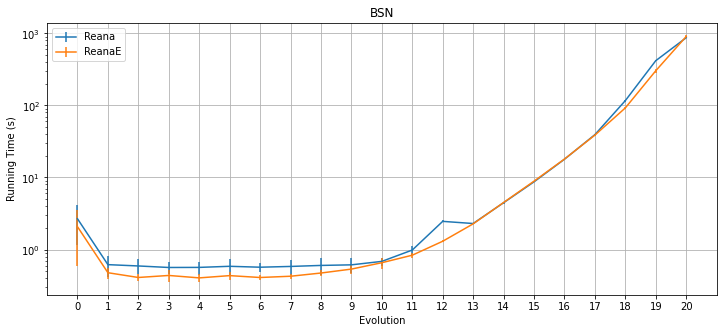

11


/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


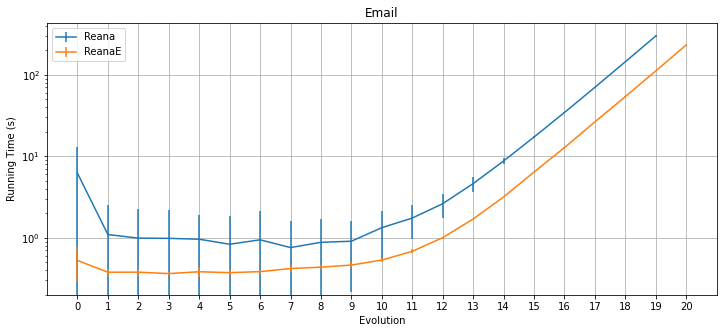

11


/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


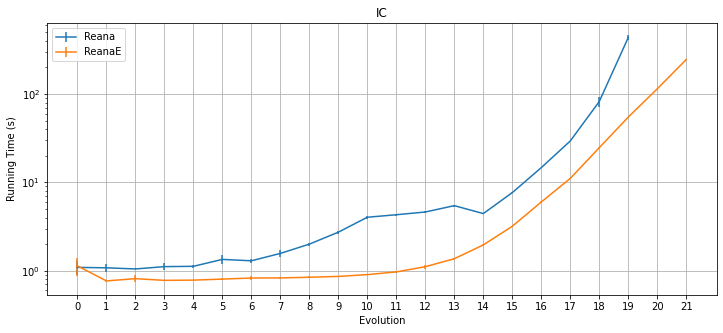

11


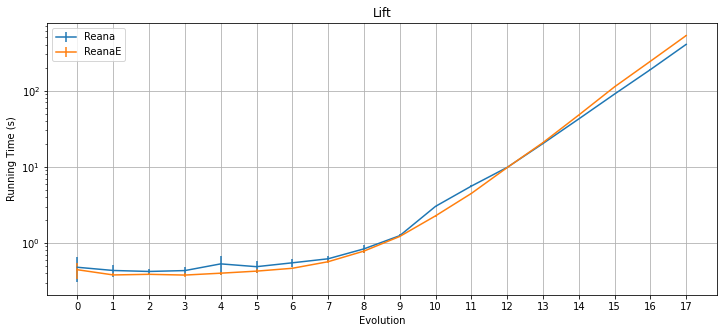

11


/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


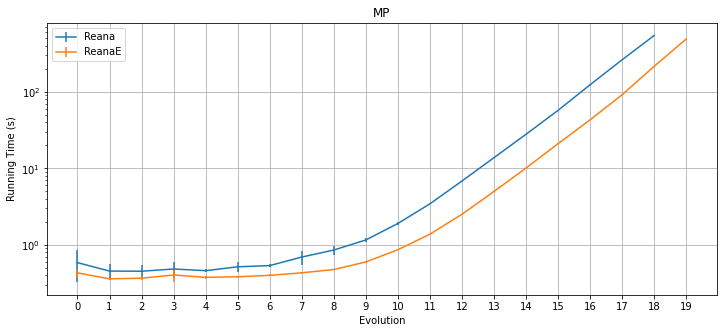

In [68]:
spls = ['BSN', 'Email', 'IC', 'Lift', 'MP']
for spl in spls:
    df = read_data(spl)
    make_line_graph(df, spl, yscale='log', filename='{}.png'.format(spl))

In [73]:
df_email = read_data('Email')
reana_std = np.std(df_email.loc['reana'])
reana_mean = np.mean(df_email.loc['reana'])
df_email, reana_mean, reana_std

11


(                0      1      2      3      4      5      6      7      8  \
 reana  0    0.389  0.431  0.398  0.406  0.447  0.417  0.466  0.460  0.722   
        1    2.133  0.482  0.449  0.424  0.436  0.452  0.447  0.457  0.499   
        2    2.262  0.415  0.411  0.413  0.767  0.590  0.446  0.469  0.681   
        3    2.489  0.408  0.411  0.469  0.456  0.450  0.526  0.475  0.525   
        4    4.711  0.463  0.458  0.423  0.432  0.431  0.800  0.454  0.540   
        5    3.642  0.401  0.412  0.406  0.777  0.421  0.513  0.472  0.560   
        6    8.870  1.141  0.700  0.447  0.447  0.502  0.824  0.506  1.087   
        7    6.034  1.065  1.696  1.554  1.629  0.807  0.633  0.491  0.495   
        8    5.289  0.983  0.612  0.682  0.429  0.448  0.476  0.580  0.480   
        9   27.085  5.608  4.840  4.742  3.711  4.067  4.751  3.402  3.410   
        10   5.357  0.663  0.521  0.872  1.041  0.587  0.515  0.585  0.690   
 reanae 0    0.431  0.362  0.349  0.354  0.355  0.373  0.400  0.

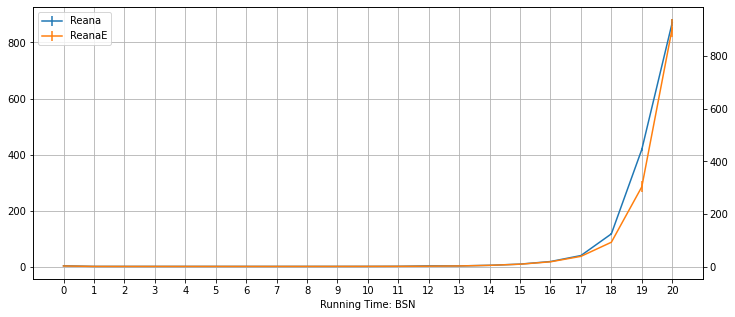

In [58]:
reana_mean = np.mean(df.loc['reana'])
reana_std = np.std(df.loc['reana'])
reanae_mean = np.mean(df.loc['reanae'])
reanae_std = np.std(df.loc['reanae'])

df_mean = pd.concat([reana_mean, reanae_mean], keys=['reana', 'reanae'])

plt.figure(figsize=(12,5))
plt.xlabel('Running Time: BSN')

ax1 = df_mean['reana'].plot(grid=True, yerr=reana_std, label='Reana')
ax2 = df_mean['reanae'].plot(grid=True, secondary_y=True, yerr=reanae_std, label='ReanaE')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

xticks = np.arange(0, df_mean['reanae'].shape[0], 1)
ax1.set_xticks(xticks)
ax2.set_xticks(xticks)

# plt.errorbar(x, y + 3, yerr=yerr, label='both limits (default)')

plt.legend(h1+h2, l1+l2, loc=2)
plt.yscale('linear')
plt.show()

In [59]:
reanae_std

0      1.478407
1      0.081924
2      0.048159
3      0.076908
4      0.054830
5      0.053604
6      0.027394
7      0.038562
8      0.042317
9      0.078692
10     0.112792
11     0.062677
12     0.045193
13     0.028923
14     0.114484
15     0.117038
16     0.239090
17     0.675731
18     1.998218
19    20.768019
20    33.389497
dtype: float64

/home/breno/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:364: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


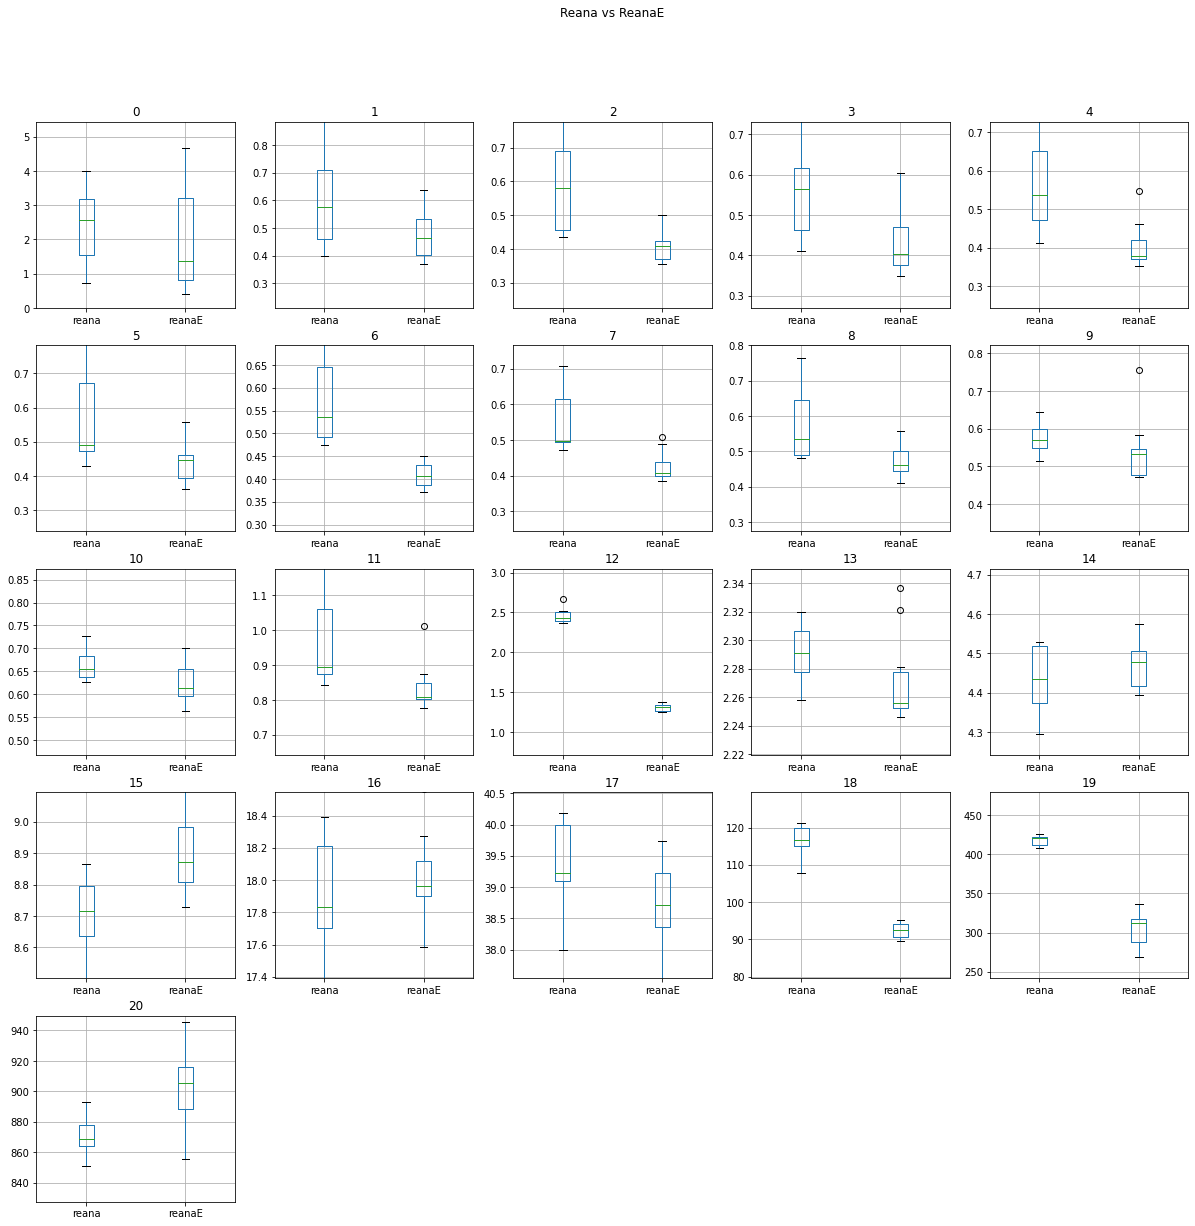

In [61]:
# df = np.log10(df)

# fig, ax1 = plt.subplots()
# df.loc['reana'].boxplot(figsize=(14,14))

# ax2 = ax1.twinx()
# df.loc['reanae'].boxplot()

# plt.show()
# plt.figure();
# axes = df.boxplot(by='Type', figsize=(20,20), return_type='axes')
# print(axes)
means = np.mean(df)
stdevs = np.std(df)

fig, ax_new = plt.subplots(5, 5, sharex=False, sharey=False, figsize=(20,20))
fig.delaxes(ax_new[4,1])
fig.delaxes(ax_new[4,2])
fig.delaxes(ax_new[4,3])
fig.delaxes(ax_new[4,4])
bp = df.boxplot(by="Type",ax=ax_new.flatten()[:21], figsize=(6,8))
# [ax_tmp.set_xlabel('Type') for ax_tmp in ax_new.reshape(-1)]

for i in range(21):
# for i in range(1):
    mean = means[i]
    stdev = stdevs[i]
    ax_new.flatten()[i].set_ylim(max(0, mean-2*stdev),mean+2*stdev)
    ax_new.flatten()[i].set_xlabel('')
    
fig.suptitle('Reana vs ReanaE')
plt.show()

In [279]:
len(ax_new.flatten())

25

/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


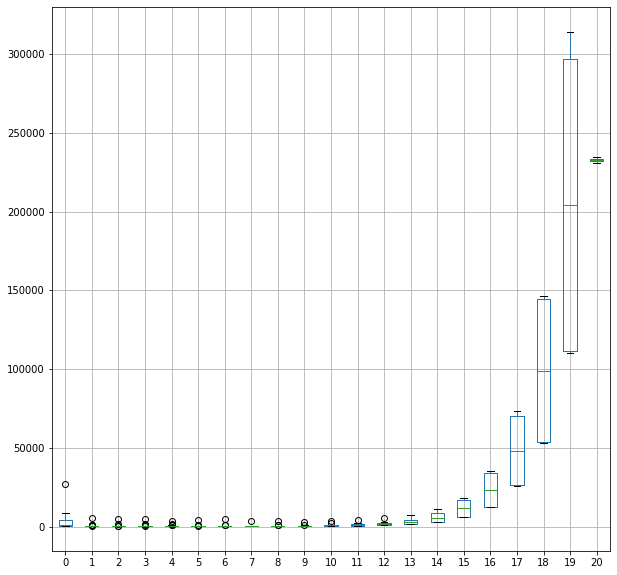

In [114]:
boxplot = df.boxplot(figsize=(10,10))
boxplot

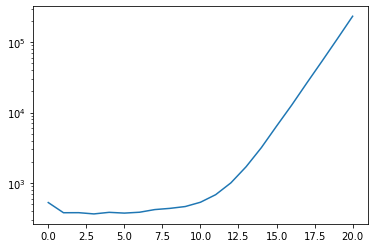

In [101]:
ts.plot(logy=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4475818e0>,
      dtype=object)

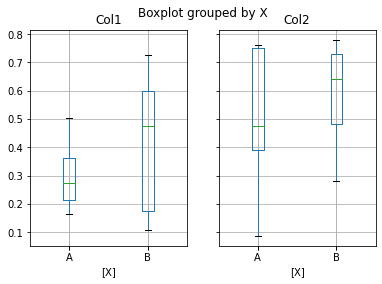

In [159]:
dft = pd.DataFrame(np.random.rand(10, 2), columns=['Col1', 'Col2'])
dft['X'] = pd.Series(['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B'])
dft.boxplot(by='X')